# Main

this notebook is the main file of the project, here the model are trained and evaluated

# Import libraies

In [1]:
#coustom modules
from train import Trainer
from models import Generator, Critic
import data.data_preprocessing as data_prep
import utils
from rescale_generated import Rescale

#pytorch modules
import torch
from torch.utils.data import DataLoader

#general modules
import matplotlib.pyplot as plt
import numpy as np

c:\Users\bolla\miniconda3\envs\torch_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Create the dataset

The following function transform the data bere using them as input for the model.

In [3]:
#create the transformer to scale the series
class ScaleInput:
    
    def __init__(self, scale) -> None:
        self.scale = scale

    def __call__(self, sample):
        return sample * self.scale

class Magnitude_Scaler:

    def __init__(self, scale):
        self.scale = scale

    def __call__(self, sample):

        cap = torch.max(sample) * self.scale
        bottom = torch.min(sample) * self.scale

        X_std = (sample - bottom) / (cap - bottom)
        X_scaled = X_std * (cap - bottom) + bottom
        
        return X_scaled

the following code create the dataset and plot some sample of the dataset series

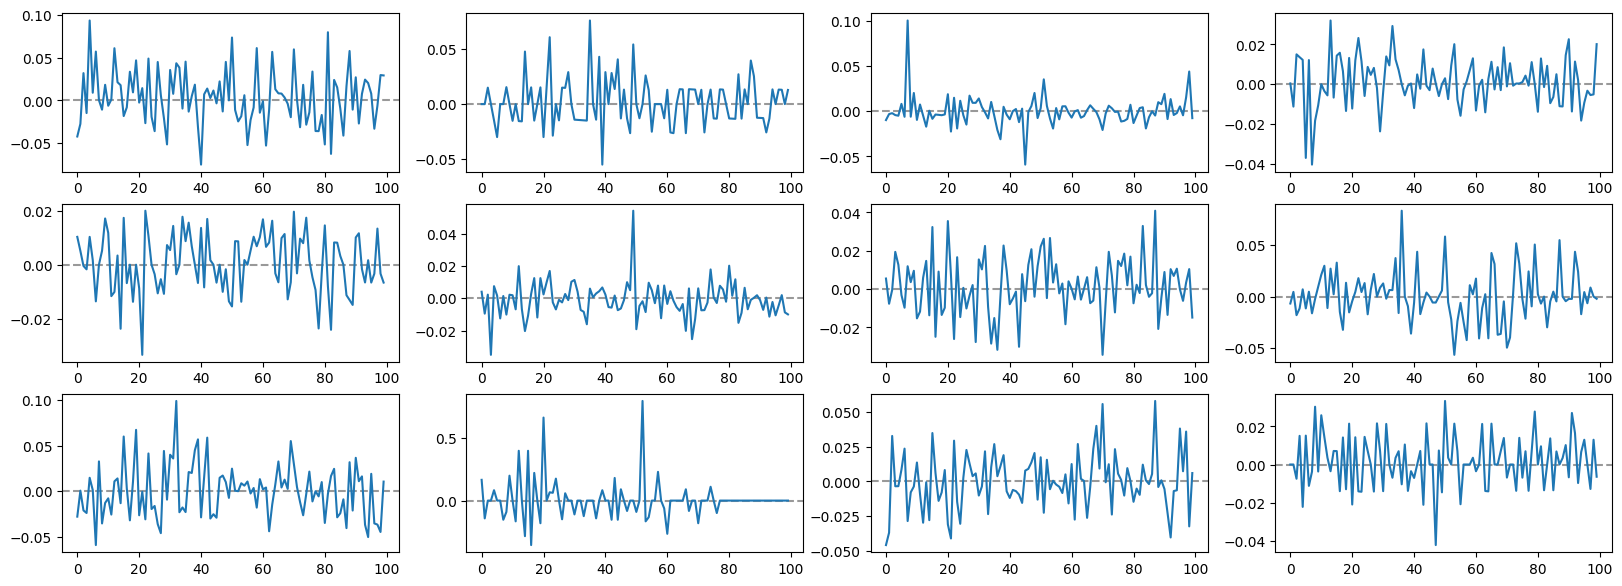

In [41]:
#initialize the transformer
scaler = ScaleInput(100)
#create the dataset
dataset = data_prep.WindowsDaset(r'data\dataset_100_winds')#,transform = scaler)
#plot some series
rows = 3
columns = 4
fig, axs = plt.subplots(rows, columns, figsize=(20,7))
for ax, i in zip(axs.ravel(),np.random.randint(0, len(dataset),size=rows * columns)):
    ax.axhline(0, color = 'black', alpha =0.4, ls = '--')
    ax.plot(dataset[i])

# Model initialization and training

the following box of code contains all the hyperparameters for the model training

In [22]:
#chose the Base directiory to save the run
BASE_DIR = r'C:\Users\bolla\Desktop\CUHK_courses\IASP_elisa\runs'

#global variables for the run
GP_WEIGHT = 10
G_NORM_PEN = 5
CRITIC_IT = 5
PRINT_EVERY = 10
CHECKPOINT_FREQ = 10
BATCH_SIZE = 256
LOG_NAME = 'run_1_0'
EPOCHS = 40

run_ARCHIVE = utils.create_dir(BASE_DIR,'000_007')

In [84]:
import importlib
import models
importlib.reload(models)
from models import Generator, Critic

import train
importlib.reload(train)
from train import Trainer

The following is the core of model training:

run the following cell to further train a model

In [18]:
# Instantiate Generator and Critic + initialize weights
from checkpoints import models as models_test
state_dicts = torch.load('checkpoints/epoch_39.pkl', map_location=torch.device('cpu'))

g = models_test.Generator()
g.load_state_dict(state_dicts['g_state_dict'])
g_opt = torch.optim.RMSprop(g.parameters(), lr=0.05)
#adam optimizer beta1 = 0.5 beta2 .99 lr = 0.003
#grater for discriminator the lr


c = models_test.Critic()
c.load_state_dict(state_dicts['d_state_dict'])
c_opt = torch.optim.RMSprop(c.parameters(), lr=0.05)


run the following cell to train a new model

In [ ]:
g = Generator()
#g_opt = torch.optim.Adam(g.parameters(), lr=0.003, betas=[0.5, 0.99])
g_opt = torch.optim.RMSprop(g.parameters(), lr=0.1)

c = Critic()
#c_opt = torch.optim.Adam(c.parameters(), lr=0.009, betas=[0.5, 0.99])
c_opt = torch.optim.RMSprop(c.parameters(), lr=0.05)

In [ ]:
#create the dataloader
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE)

# Instantiate Trainer
trainer = Trainer(g, c, g_opt, c_opt,GP_WEIGHT,G_NORM_PEN,CRITIC_IT,PRINT_EVERY,CHECKPOINT_FREQ, ARCHIVE_DIR=run_ARCHIVE)
# Train model
print('Training is about to start...')

trainer.train(data_loader, epochs=EPOCHS, plot_training_samples=True, checkpoint=None)

# Evaluate the model

the following code rescale use the model to generate samples of returns and plot the results

In [11]:
import rescale_generated
importlib.reload(rescale_generated)
from rescale_generated import Rescale


In [12]:
#create a non-transformed dataset to initialize the rescaler
plain_dataset = data_prep.WindowsDaset(r'data\dataset_100_winds')
#initialize the rescaler
rescaler = Rescale(plain_dataset, picks_range=0.02)

~Scaler initialization~
~computing the min and max quantiles~


100%|██████████| 10353/10353 [03:37<00:00, 47.68it/s]


~computing the distance between peaks~


100%|██████████| 10353/10353 [01:33<00:00, 111.08it/s]


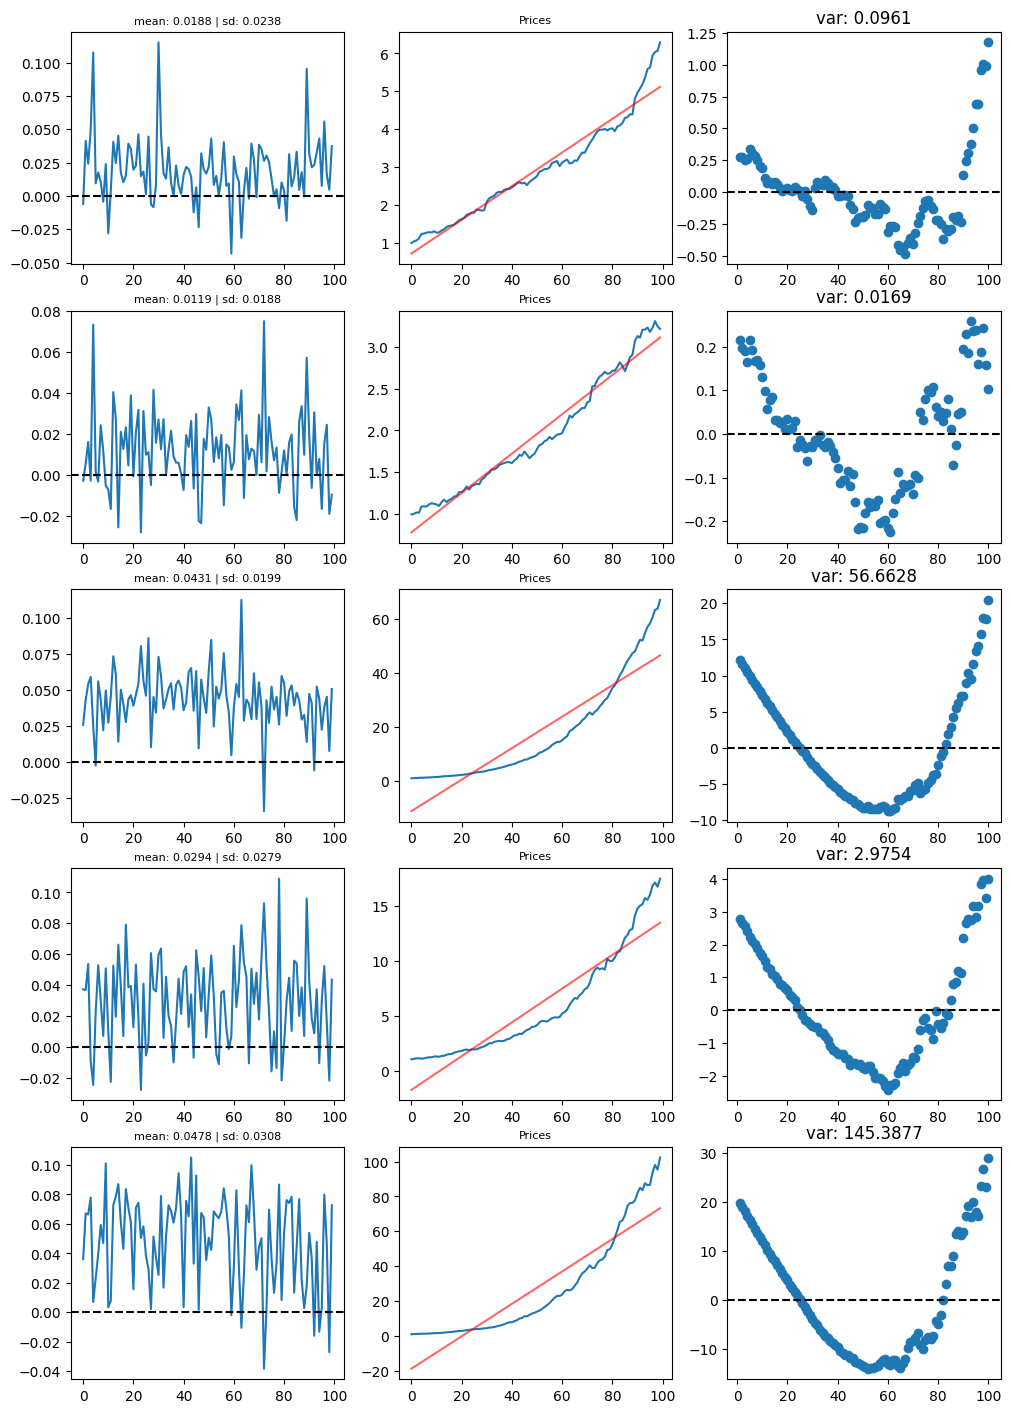

In [37]:
sample = utils.generate_sample(g,5)
scaled = []
#scale the generated series
for i in sample:
    scaled.append(rescaler.scale(i.flatten()))
    
prices, residuals, params = utils.plot_samples_price(scaled, save='results/pure_1.png', return_series=True)

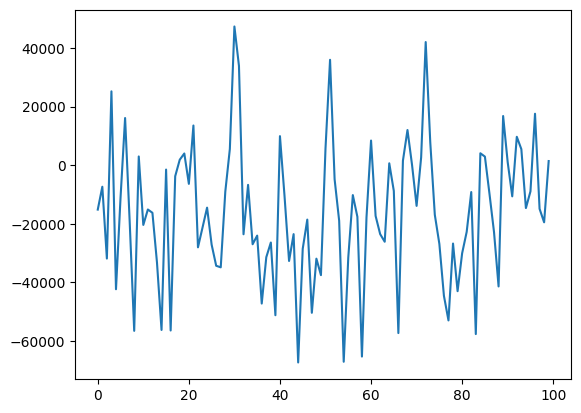

In [35]:
plt.plot(sample[2][0].detach().numpy())

In [7]:
import importlib
import generate_syntetic_df
importlib.reload(generate_syntetic_df)
import generate_syntetic_df
from generate_syntetic_df import DfGenerator

import utils
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\bolla\\Desktop\\CUHK_courses\\IASP_elisa\\final\\utils.py'>

In [21]:
df_generator = DfGenerator(variance_th=6, mean_boundary = 0.006, max_range=0.15, generator=g, size = 10, rescaler=rescaler)
syntetic_df, diff = df_generator()

iteration N: 0
iteration N: 1
iteration N: 2
iteration N: 3
iteration N: 4
iteration N: 5
iteration N: 6
iteration N: 7
iteration N: 8
iteration N: 9
iteration N: 10
iteration N: 11
iteration N: 12
iteration N: 13
iteration N: 14
iteration N: 15
iteration N: 16
iteration N: 17
iteration N: 18
iteration N: 19
iteration N: 20
iteration N: 21
iteration N: 22
iteration N: 23
iteration N: 24
iteration N: 25
iteration N: 26
iteration N: 27
iteration N: 28
iteration N: 29
iteration N: 30
iteration N: 31
iteration N: 32
iteration N: 33
iteration N: 34
iteration N: 35
iteration N: 36
iteration N: 37
iteration N: 38
iteration N: 39
iteration N: 40
iteration N: 41
iteration N: 42
iteration N: 43
iteration N: 44
iteration N: 45
iteration N: 46
iteration N: 47
iteration N: 48
iteration N: 49
iteration N: 50
iteration N: 51
iteration N: 52
iteration N: 53
iteration N: 54
iteration N: 55
iteration N: 56
iteration N: 57
iteration N: 58
iteration N: 59
iteration N: 60
iteration N: 61
iteration N: 62
it

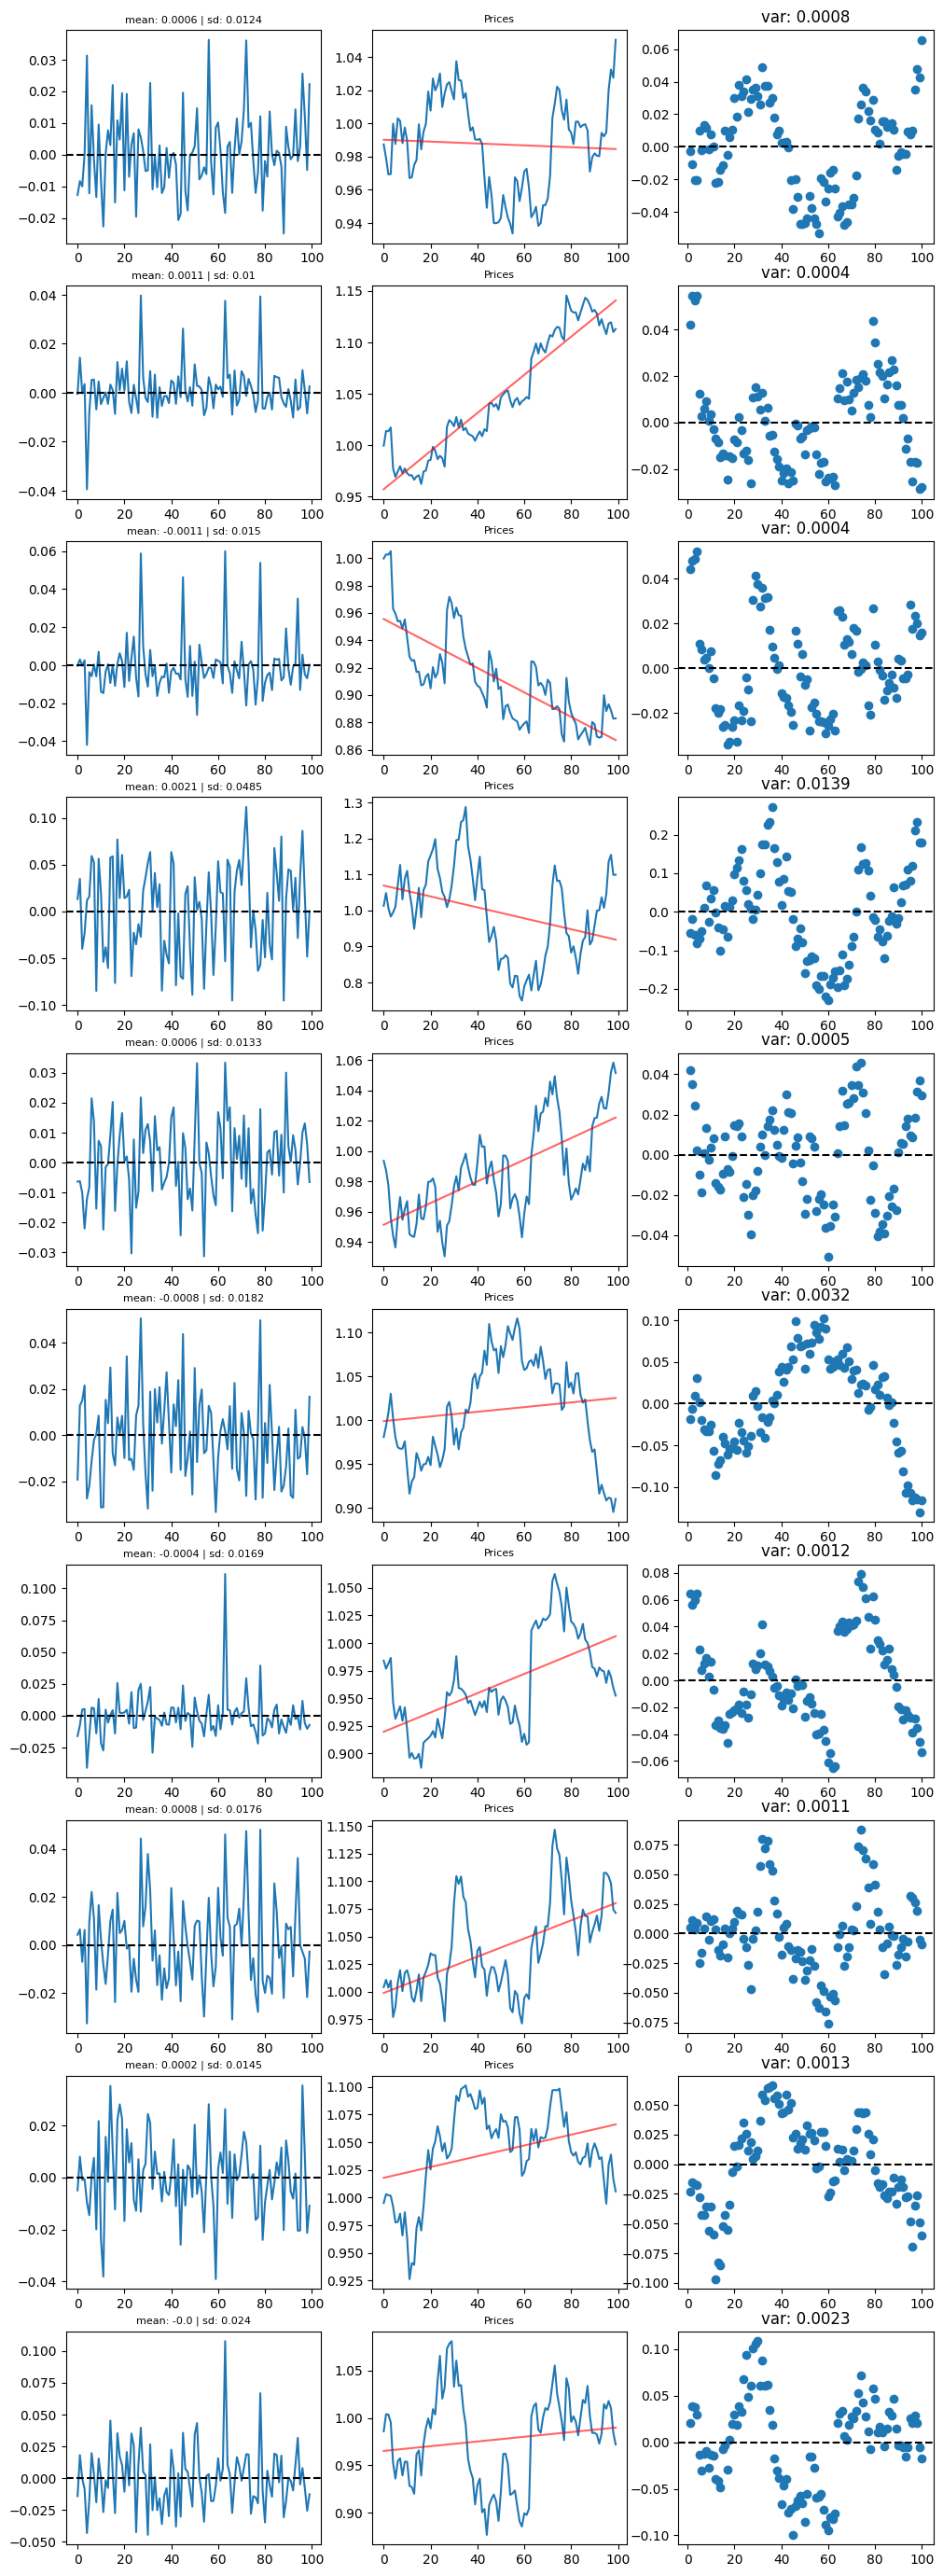

In [22]:
utils.plot_samples_price(syntetic_df, save='results/mean_range02.png', return_series=False)

In [258]:
import data
importlib.reload(data.data_preprocessing)
import data.data_preprocessing as data_prep

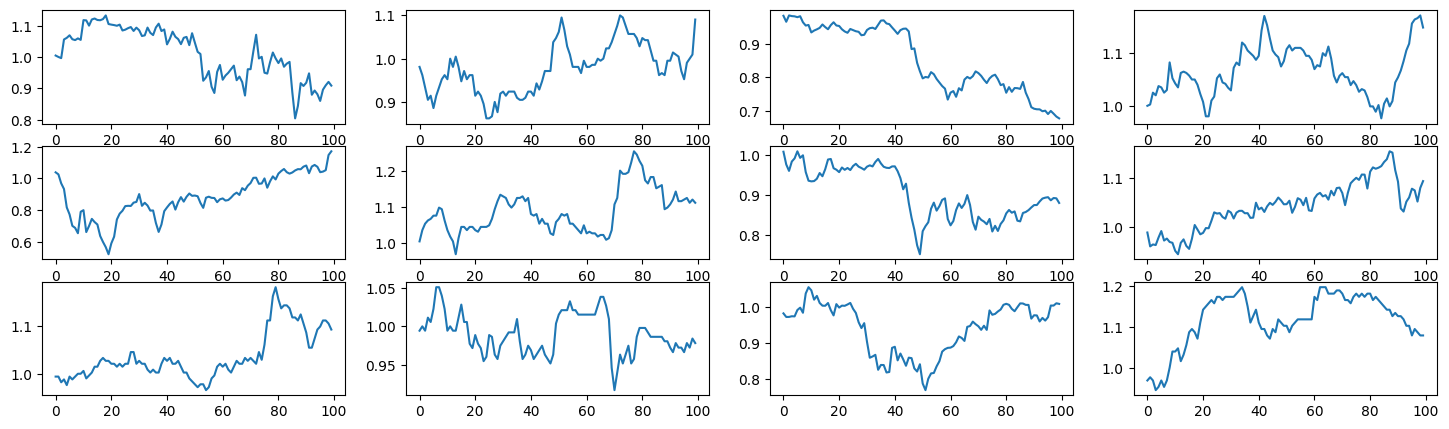

In [260]:
np.random.seed(0)
#initialize the transformer
scaler = ScaleInput(100)
#create the dataset
dataset = data_prep.WindowsDaset(r'data\dataset_100_winds', data='price')
#plot some series
rows = 3
columns = 4
fig, axs = plt.subplots(rows, columns, figsize=(18,5))
for ax, i in zip(axs.ravel(),np.random.randint(0, len(dataset),size=rows * columns)):
    ax.plot(dataset[i])